In [1]:
import os
import gym
import math
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image
from statsmodels.tsa.stattools import coint, adfuller

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

from stock_trading_environment import StockTradingEnvironment, Positions

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            df = data[[keys[i], keys[j]]].dropna()
            S1 = df[keys[i]]
            S2 = df[keys[j]]
            result = coint(S1, S2)    #statsmodel built-in cointegration hypothesis test
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:    #reject null: there should be cointegration
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs



def uniquify(path):
    filename, extension = os.path.splitext(path)
    counter = 1

    while os.path.exists(path):
        path = filename + " (" + str(counter) + ")" + extension
        counter += 1

    return path

In [3]:
directory = './data/主题行业类'
data_pairs = []
for filename in os.listdir(directory):
    df = pd.read_excel(os.path.join(directory, filename), header=1, index_col=0, skiprows=0)
    _, _, pairs = find_cointegrated_pairs(df)
    data_pairs.extend([df[list(pair)].dropna().copy() for pair in pairs])

print(len(data_pairs))

224


In [5]:
df.keys()

Index(['603919.SH', '603779.SH', '603589.SH', '603369.SH', '603198.SH',
       '601579.SH', '600809.SH', '600779.SH', '600702.SH', '600616.SH',
       '600600.SH', '600573.SH', '600559.SH', '600543.SH', '600519.SH',
       '600365.SH', '600238.SH', '600199.SH', '600197.SH', '600132.SH',
       '600084.SH', '600059.SH', '002646.SZ', '002568.SZ', '002461.SZ',
       '002304.SZ', '000995.SZ', '000929.SZ', '000869.SZ', '000860.SZ',
       '000858.SZ', '000799.SZ', '000752.SZ', '000729.SZ', '000596.SZ',
       '000568.SZ'],
      dtype='object')

In [24]:
data_pairs[0]

,603323.SH,601229.SH
Date,,
2016-11-29,9.84,26.53
2016-11-30,10.82,26.20
2016-12-01,11.90,26.30
2016-12-02,13.09,25.74
2016-12-05,14.40,25.80
...,...,...
2021-07-14,4.57,7.45
2021-07-15,4.70,7.52
2021-07-16,4.66,7.49


[('603919.SH', '600199.SH'), ('603919.SH', '600059.SH'), ('603919.SH', '000995.SZ'), ('603779.SH', '600543.SH'), ('603779.SH', '600365.SH'), ('603779.SH', '600084.SH'), ('603779.SH', '000752.SZ'), ('603589.SH', '600132.SH'), ('603589.SH', '002304.SZ'), ('603589.SH', '000752.SZ'), ('603198.SH', '600702.SH'), ('603198.SH', '600059.SH'), ('601579.SH', '600616.SH'), ('601579.SH', '600543.SH'), ('601579.SH', '600365.SH'), ('601579.SH', '600084.SH'), ('601579.SH', '000929.SZ'), ('601579.SH', '000860.SZ'), ('601579.SH', '000752.SZ'), ('600809.SH', '600132.SH'), ('600616.SH', '600600.SH'), ('600616.SH', '600573.SH'), ('600616.SH', '600559.SH'), ('600616.SH', '600543.SH'), ('600616.SH', '600519.SH'), ('600616.SH', '600365.SH'), ('600616.SH', '600084.SH'), ('600616.SH', '600059.SH'), ('600616.SH', '000995.SZ'), ('600616.SH', '000929.SZ'), ('600616.SH', '000869.SZ'), ('600616.SH', '000860.SZ'), ('600616.SH', '000858.SZ'), ('600616.SH', '000799.SZ'), ('600616.SH', '000752.SZ'), ('600616.SH', '0007

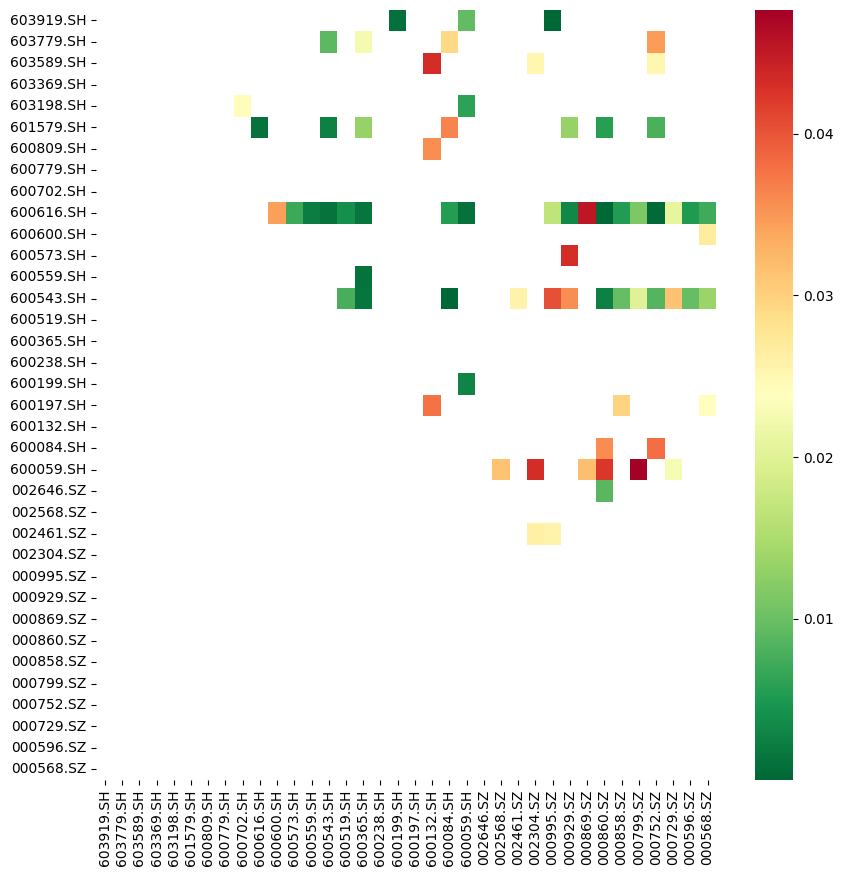

In [6]:
# Heatmap to show the p-values of the cointegration test between each pair of
# stocks. Only show the value in the upper-diagonal of the heatmap
df = pd.read_excel('./data/主题行业类/酒类.xlsx', header=1, index_col=0, skiprows=0)
tickers = df.columns
scores, pvalues, pairs = find_cointegrated_pairs(df)
import seaborn
fig, ax = plt.subplots(figsize=(10,10))
seaborn.heatmap(pvalues, xticklabels=tickers, yticklabels=tickers, cmap='RdYlGn_r', mask=(pvalues >= 0.05))
print(pairs)

In [6]:
window_size = 60
trade_period = 5

envs = []
for pair in pairs:
    data = df[list(pair)].dropna()
    if data.shape[0] > 700:
        envs.append(StockTradingEnvironment(data.copy(), window_size, trade_period))   #instantiate an env

train_size = int(len(envs) * 0.7)   #train/test split = 0.7
print(train_size)
train_envs = envs[:train_size]
test_envs = envs[train_size:]

48


In [30]:
len(envs)

69

In [26]:
pair

('002461.SZ', '000995.SZ')

In [25]:
data

,002461.SZ,000995.SZ
Date,,
2010-08-18,16.08,8.86
2010-08-19,17.69,8.65
2010-08-20,18.37,8.39
2010-08-23,17.85,8.49
2010-08-24,17.35,8.91
...,...,...
2021-07-14,10.34,28.96
2021-07-15,10.98,27.77
2021-07-16,10.84,26.56


In [7]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [8]:
class DQN(nn.Module):   #PyTorch's Module class

    def __init__(self, input_size, n_actions):
        super(DQN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(256, n_actions)
        )

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        return self.model(x.to(device))

In [9]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 5

# Get number of actions from gym action space
n_actions = 3

policy_net = DQN(window_size + 2, n_actions).to(device)
target_net = DQN(window_size + 2, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())   #from PyTorch; returns a dict of whole state of the module
target_net.eval()   #set target_net to evaluate mode

optimizer = optim.RMSprop(policy_net.parameters(), lr=1e-4)   #from torch.optim; RMSprop = optimizer like SGD or Adam
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:   #epsilon-greedy
        with torch.no_grad():   #disable tracking of grad in autograd; reduce memory usage and speed up computations; no backprop
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)   #exploit
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)   #explore, because random

In [31]:
policy_net

DQN(
  (model): Sequential(
    (0): Linear(in_features=62, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.25, inplace=False)
    (6): Linear(in_features=256, out_features=3, bias=True)
  )
)

In [10]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)   #next_state is an observation
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [22]:
#num_episodes = 100
num_episodes = 300
best_rewards = 0.0
for i_episode in range(num_episodes):
    policy_net.train()
    train_rewards = []
    train_returns = []
    for env in train_envs:
        # Initialize the environment and state
        obs = env.reset()   #reset() will get (zscore, [self._position.value, self.pvalue])
        state = torch.tensor([obs], dtype=torch.float, device=device)   
        for t in count():   #keep looping until done -> break
            # Select and perform an action
            action = select_action(state)   #epsilon-greedy: exploit or explore
            obs, reward, done, info = env.step(Positions(action.item()))
            reward = torch.tensor([reward], dtype=torch.float, device=device)

            # Observe new state
            if not done:
                next_state = torch.tensor([obs], dtype=torch.float, device=device)
            else:
                next_state = None

            # Store the transition in memory
            memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            optimize_model()
            if done:
                train_rewards.append(info['total_reward'])
                train_returns.append(info['total_return'])
                break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
    
    # Validation
    policy_net.eval()
    test_rewards = []
    test_returns = []
    with torch.no_grad():
        for env in test_envs:
            obs = env.reset()
            state = torch.tensor([obs], dtype=torch.float, device=device)
            for t in count():   #keep looping until done -> break
                # Select and perform an action
                action = policy_net(state).max(1)[1].view(1, 1)
                obs, _reward, done, info = env.step(Positions(action.item()))
                state = torch.tensor([obs], dtype=torch.float, device=device)

                if done:
                    test_rewards.append(info['total_reward'])
                    test_returns.append(info['total_return'])
                    break

    avg_rewards = np.mean(test_rewards)
    if avg_rewards > best_rewards:
        best_rewards = avg_rewards
        torch.save(policy_net.state_dict(), uniquify('./models/model.pth'))   #save trained model (policy_net) as a state_dict for future use

    print('epoch [{}/{}], train rewards:{:.4f}, return:{:.4f}, val rewards:{:.4f}, return:{:.4f}'.format
          (i_episode + 1, num_episodes, np.mean(train_rewards), np.mean(train_returns), np.mean(test_rewards),
           np.mean(test_returns)))


print('Complete')

epoch [1/300], train rewards:0.9989, return:0.9989, val rewards:0.7132, return:0.7132
epoch [2/300], train rewards:0.8344, return:0.8344, val rewards:0.8984, return:0.8984
epoch [3/300], train rewards:0.8926, return:0.8926, val rewards:0.6852, return:0.6852
epoch [4/300], train rewards:0.8282, return:0.8282, val rewards:0.4162, return:0.4162
epoch [5/300], train rewards:0.8452, return:0.8452, val rewards:0.1228, return:0.1228
epoch [6/300], train rewards:1.1079, return:1.1079, val rewards:0.3359, return:0.3359
epoch [7/300], train rewards:0.9571, return:0.9571, val rewards:0.2565, return:0.2565
epoch [8/300], train rewards:0.7804, return:0.7804, val rewards:0.6758, return:0.6758
epoch [9/300], train rewards:0.9840, return:0.9840, val rewards:0.7497, return:0.7497
epoch [10/300], train rewards:0.6632, return:0.6632, val rewards:0.5993, return:0.5993
epoch [11/300], train rewards:0.7790, return:0.7790, val rewards:0.3105, return:0.3105
epoch [12/300], train rewards:0.7430, return:0.7430,

            returns1  returns2  strategy
Date                                    
2021-07-20   0.66913  9.925442  0.645112
1.422213488647722


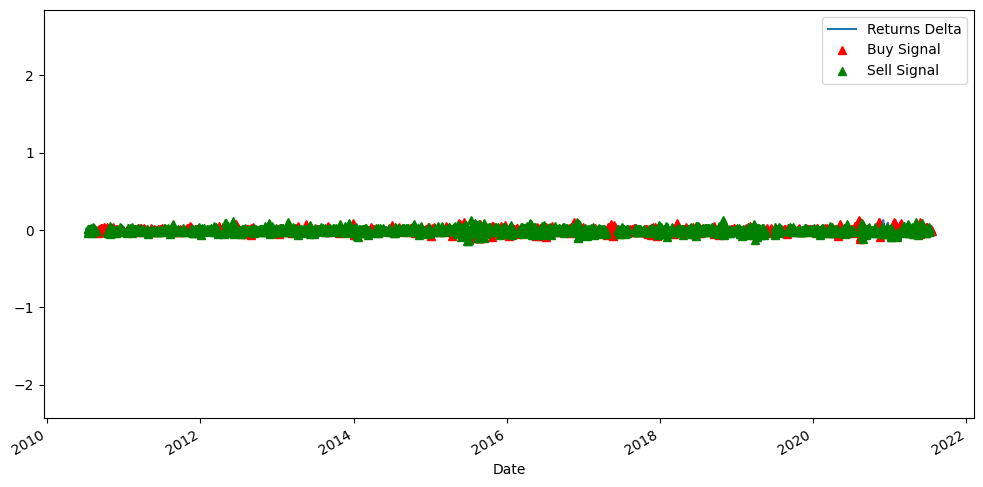

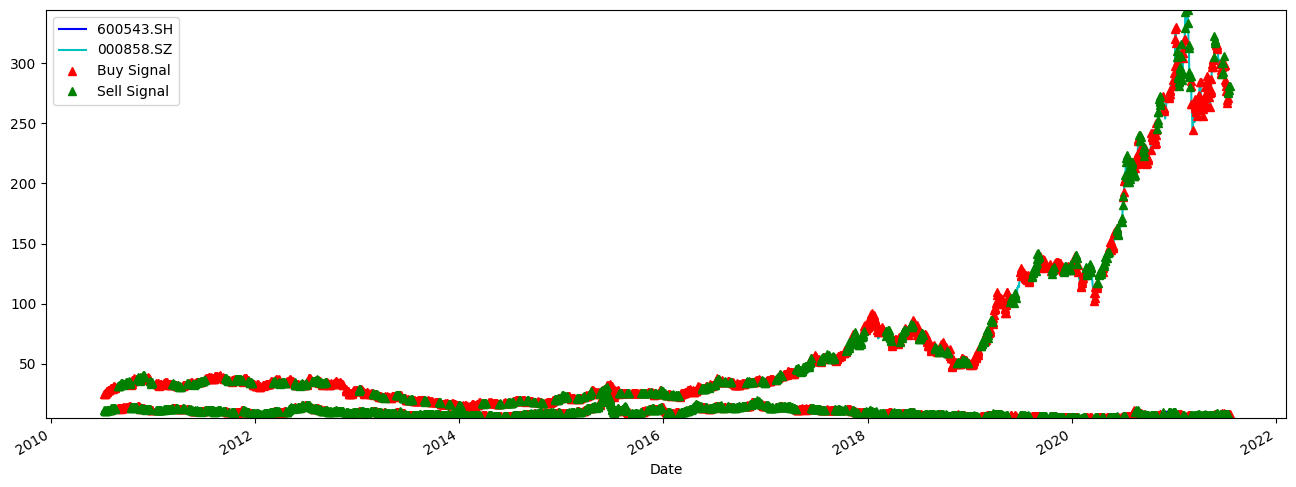

            returns1   returns2  strategy
Date                                     
2021-07-20   0.66913  15.927131    1.0271
1.9988182525214688


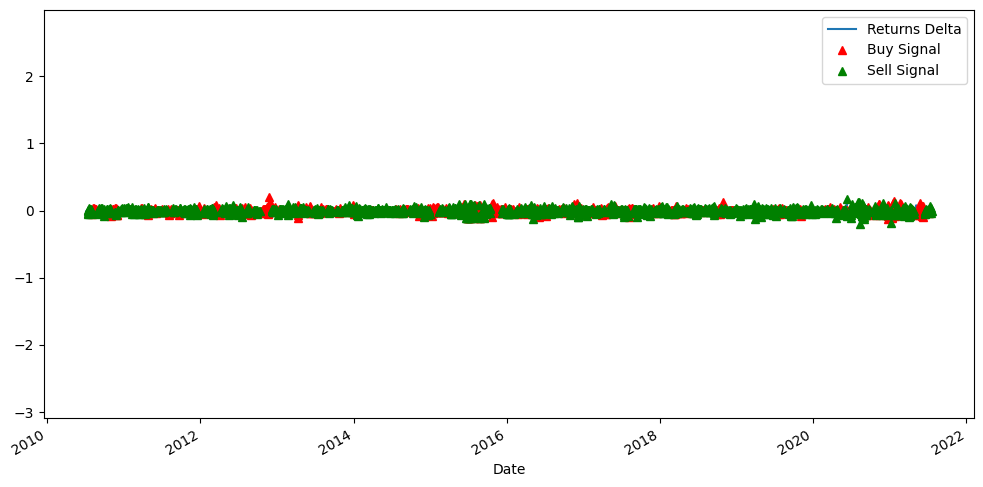

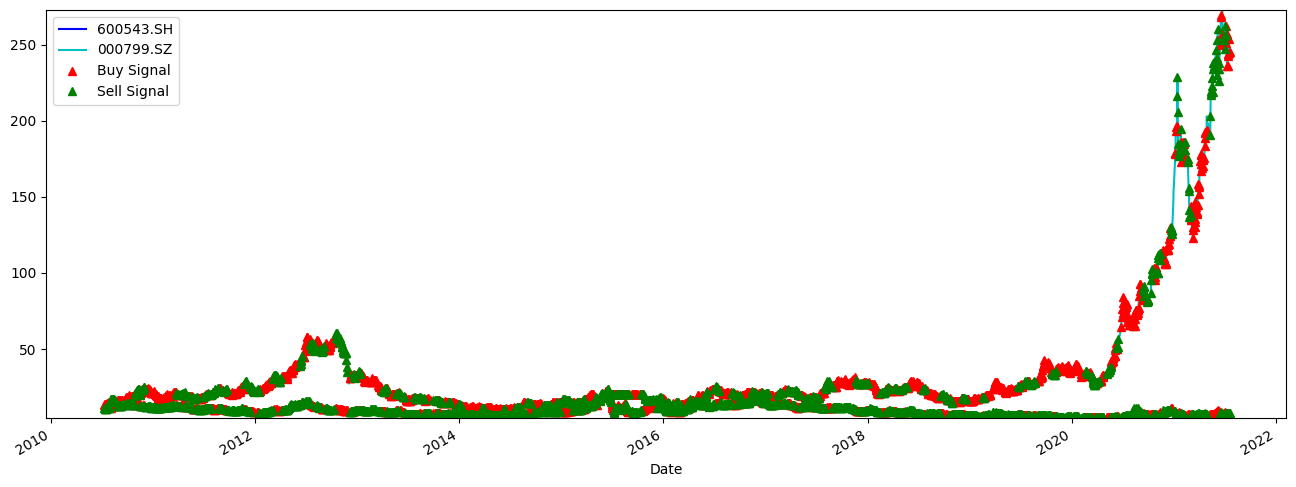

            returns1  returns2  strategy
Date                                    
2021-07-20   0.66913  0.484945   1.08671
0.8447453860484929


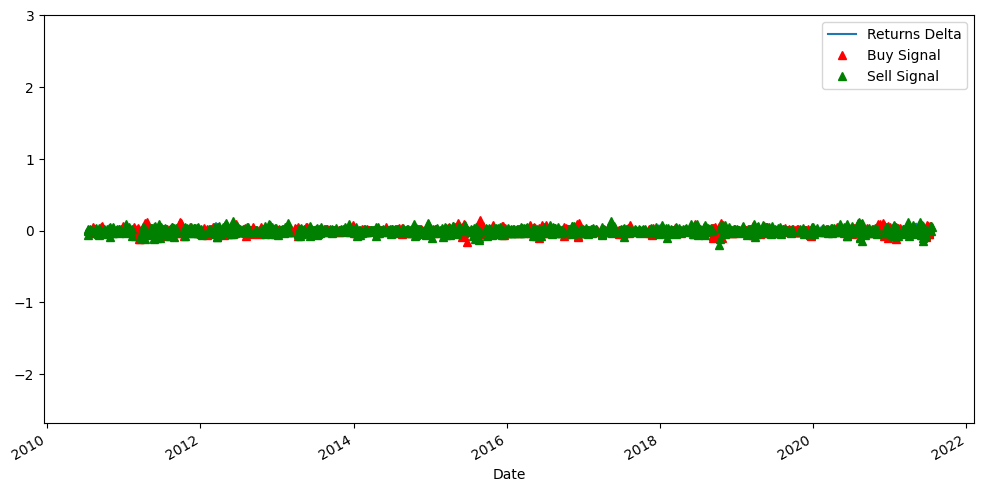

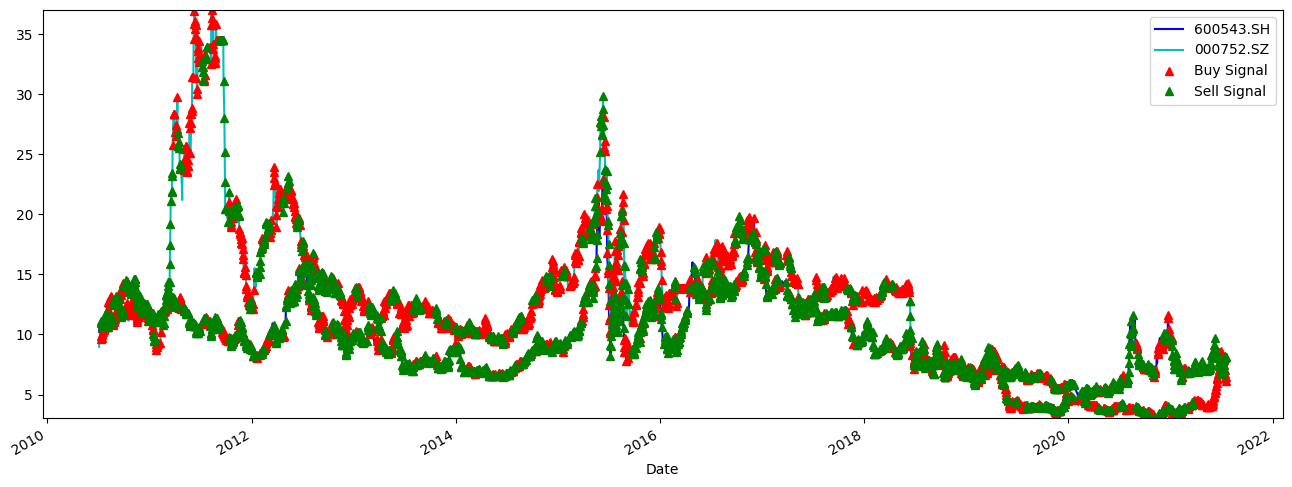

            returns1  returns2  strategy
Date                                    
2021-07-20   0.66913     0.351  1.855523
-0.03778745915264268


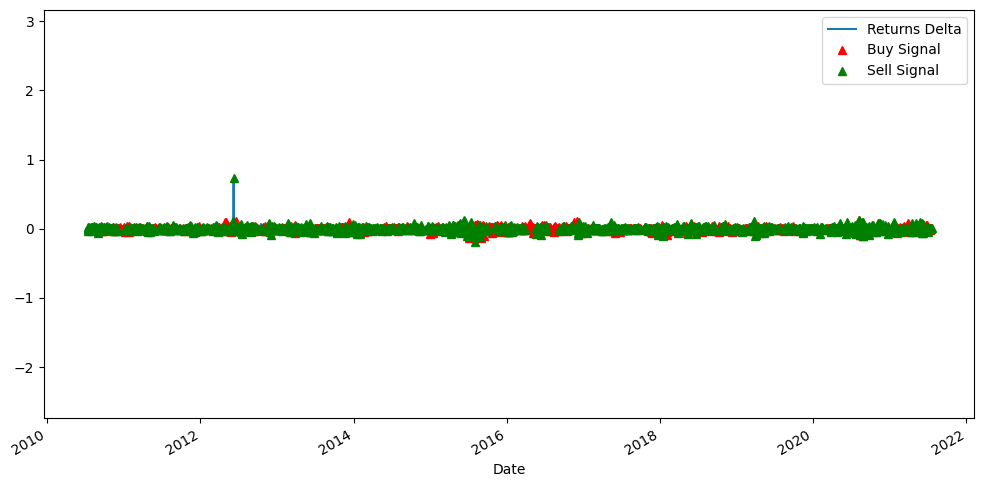

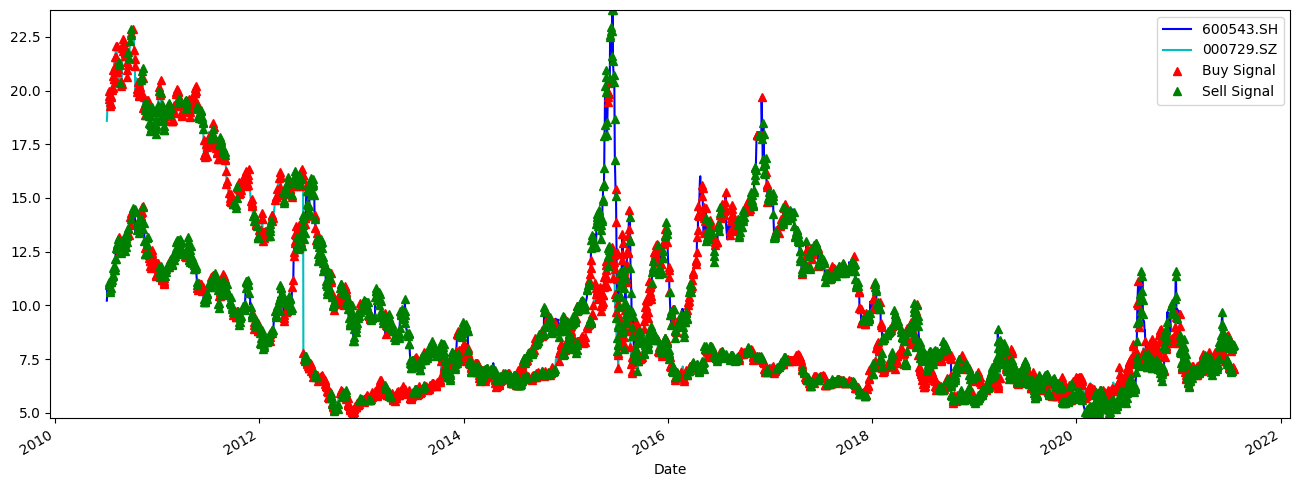

            returns1  returns2  strategy
Date                                    
2021-07-20   0.66913  5.336617  2.036261
0.3359784217298287


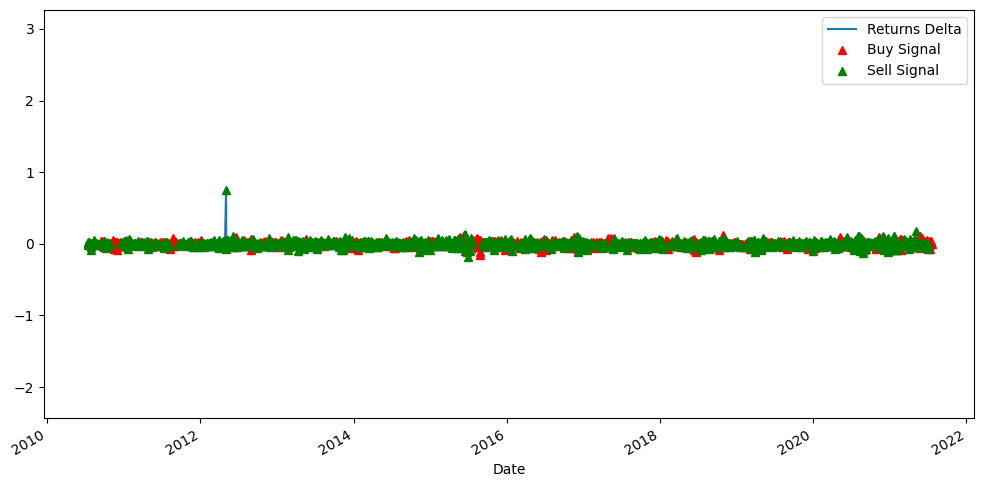

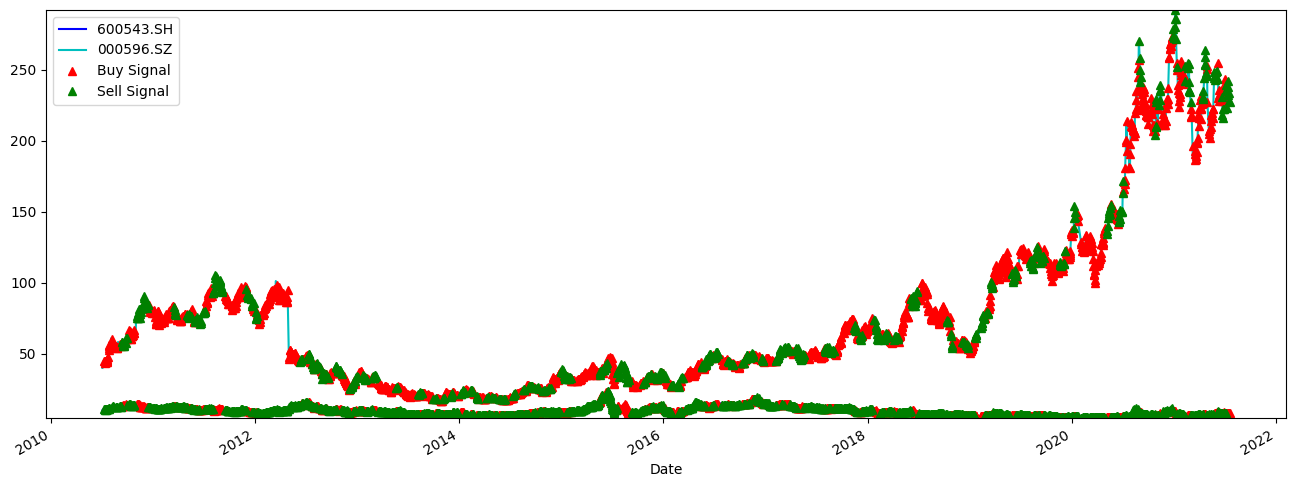

            returns1  returns2  strategy
Date                                    
2021-07-20   0.66913  7.040986  1.240744
1.882251190150763


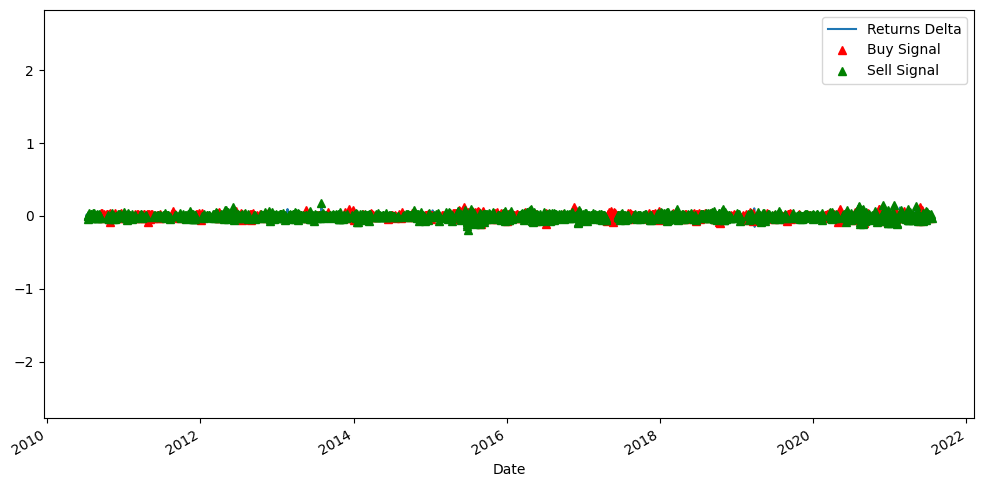

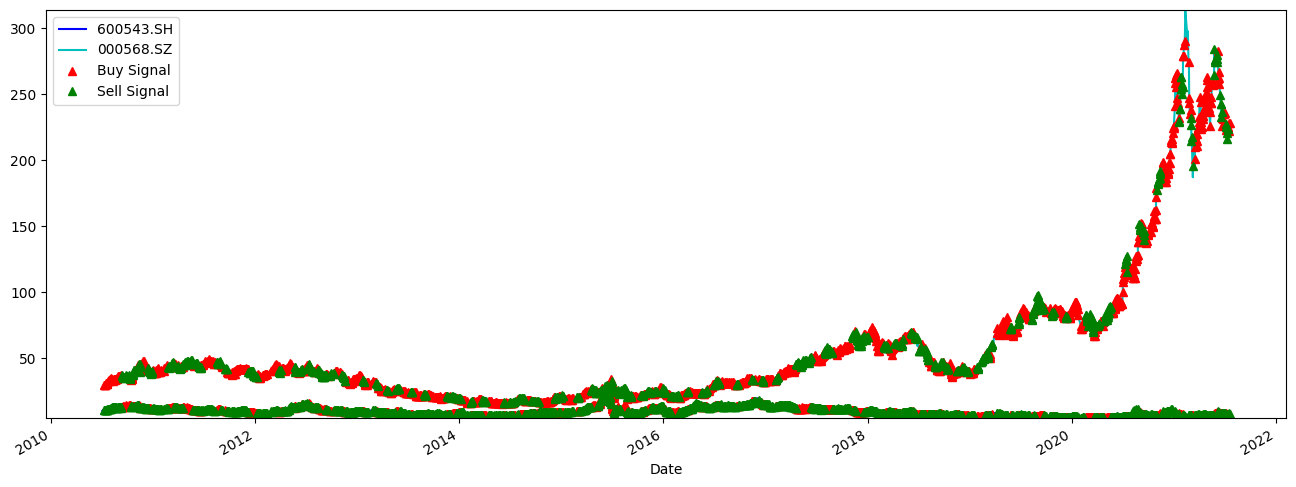

            returns1  returns2  strategy
Date                                    
2021-07-20  0.818273  1.219205  2.356748
0.6666674603870898


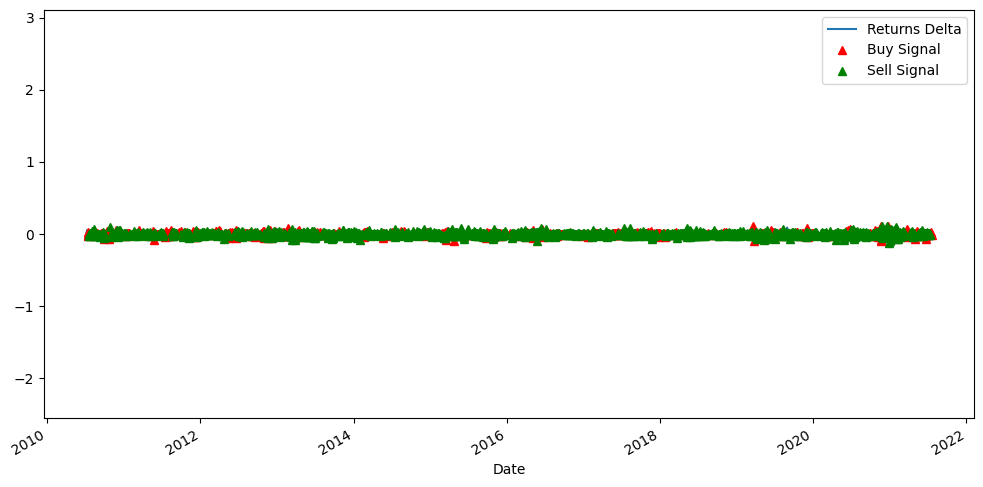

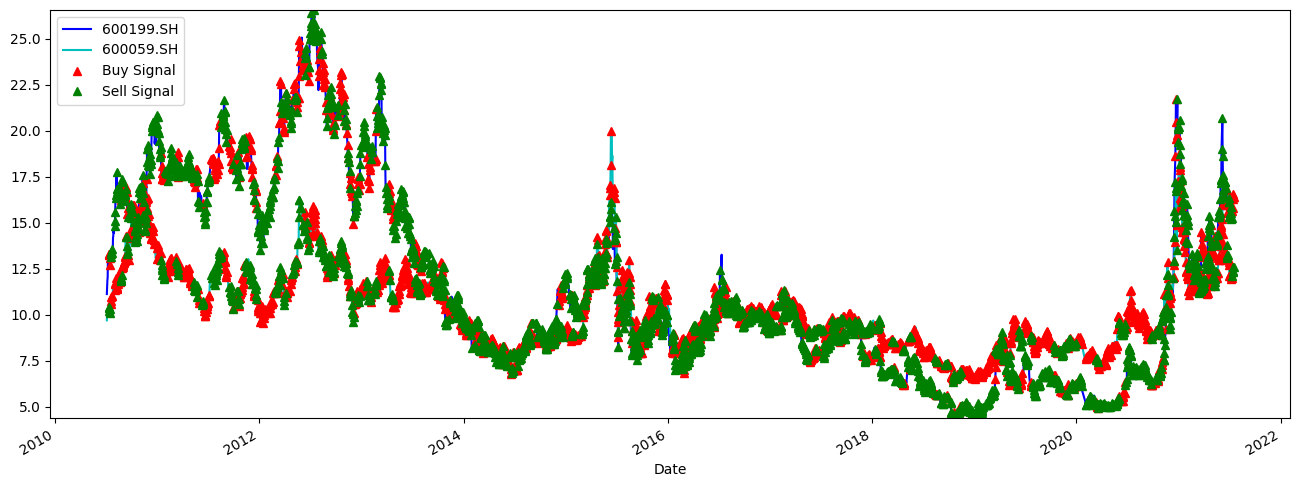

            returns1  returns2  strategy
Date                                    
2021-07-20   2.26087  6.797251  1.473448
0.3767604009676673


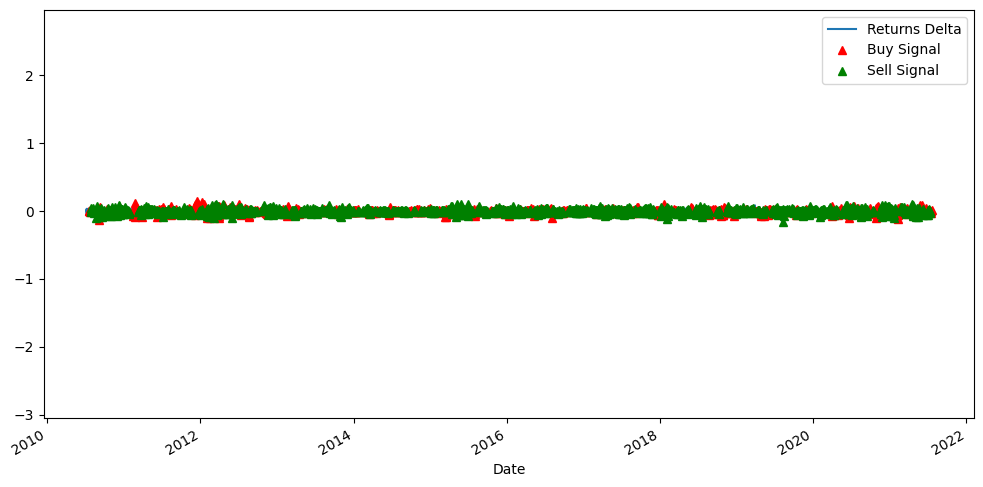

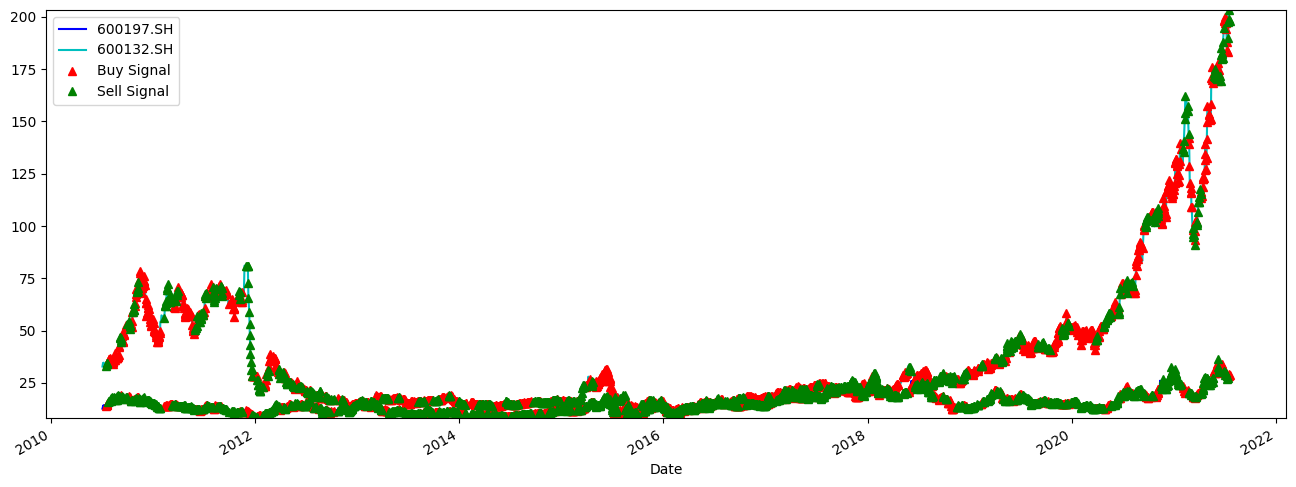

            returns1  returns2  strategy
Date                                    
2021-07-20   2.26087  9.925442   0.74416
0.8375582236653865


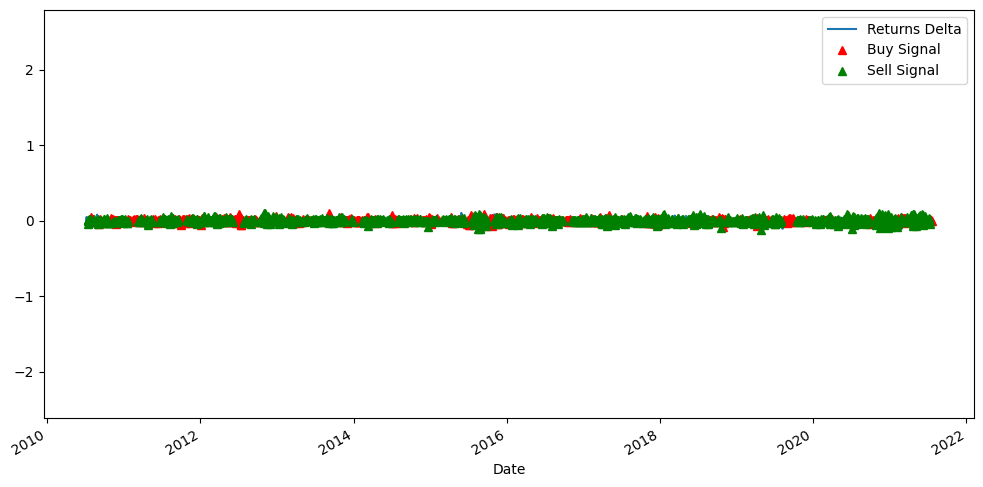

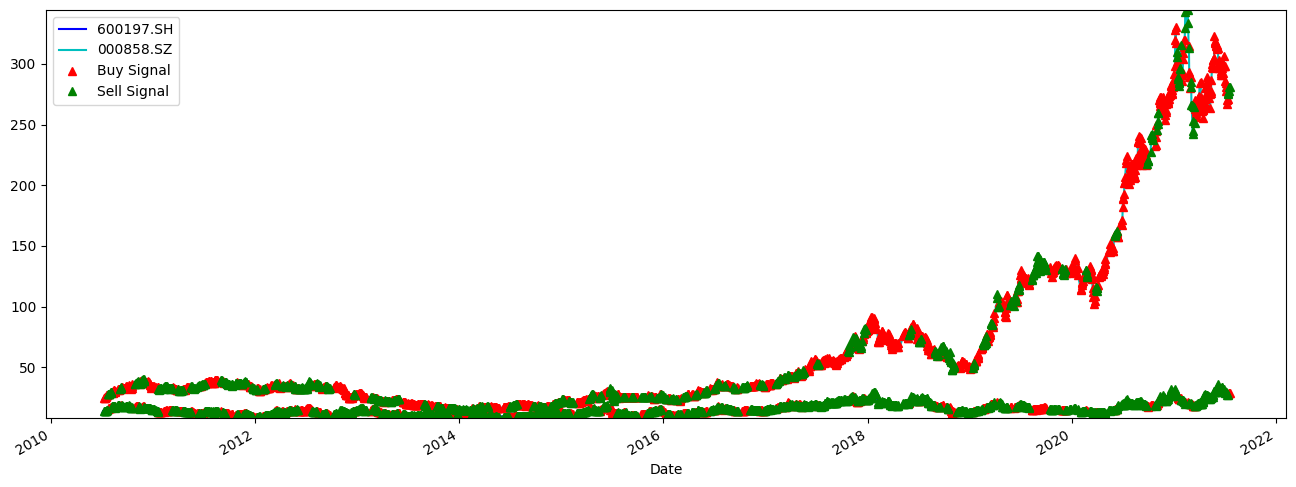

            returns1  returns2  strategy
Date                                    
2021-07-20   2.26087  7.040986  1.164282
0.2830539593082666


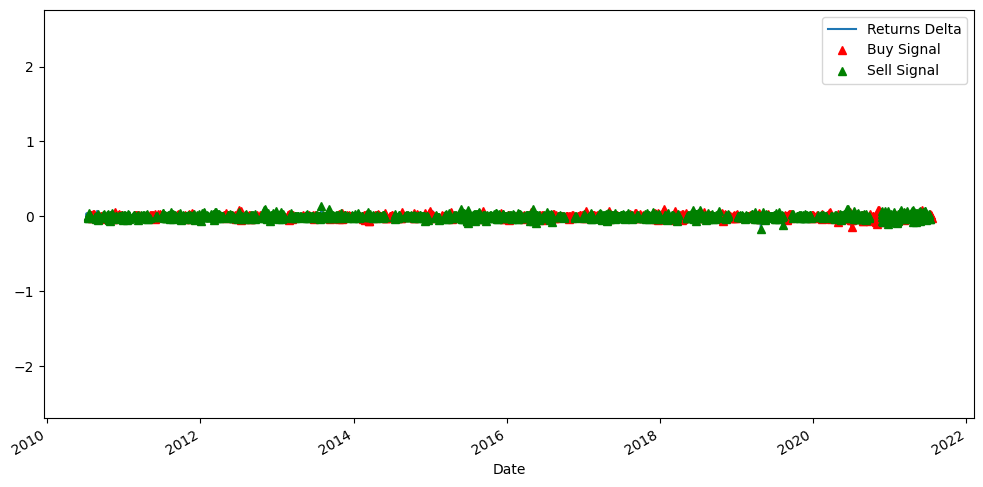

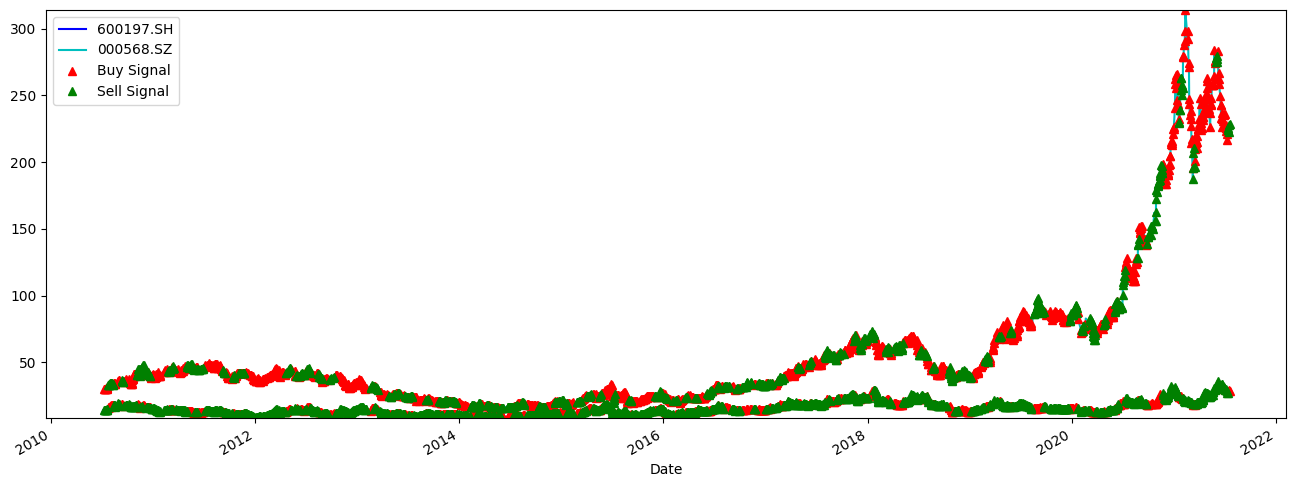

            returns1  returns2  strategy
Date                                    
2021-07-20  0.419792  2.116846  1.016785
1.7197825161382732


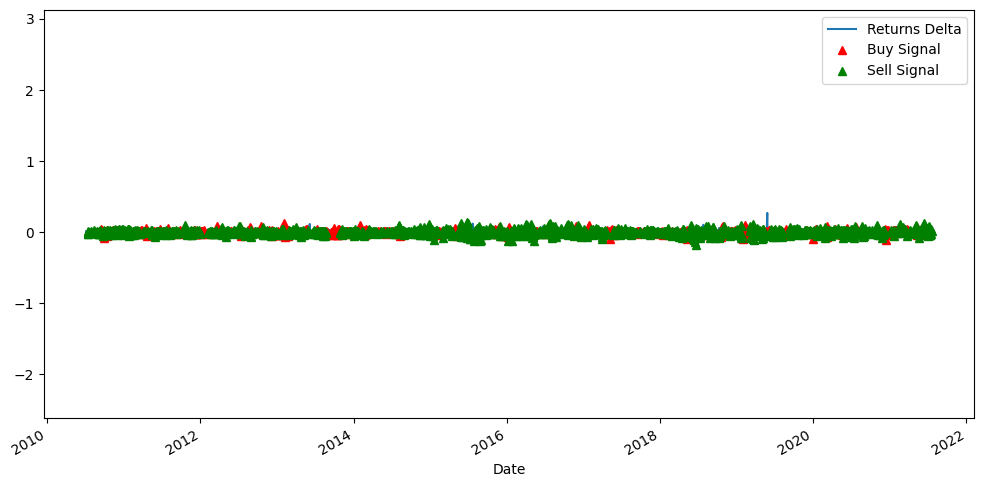

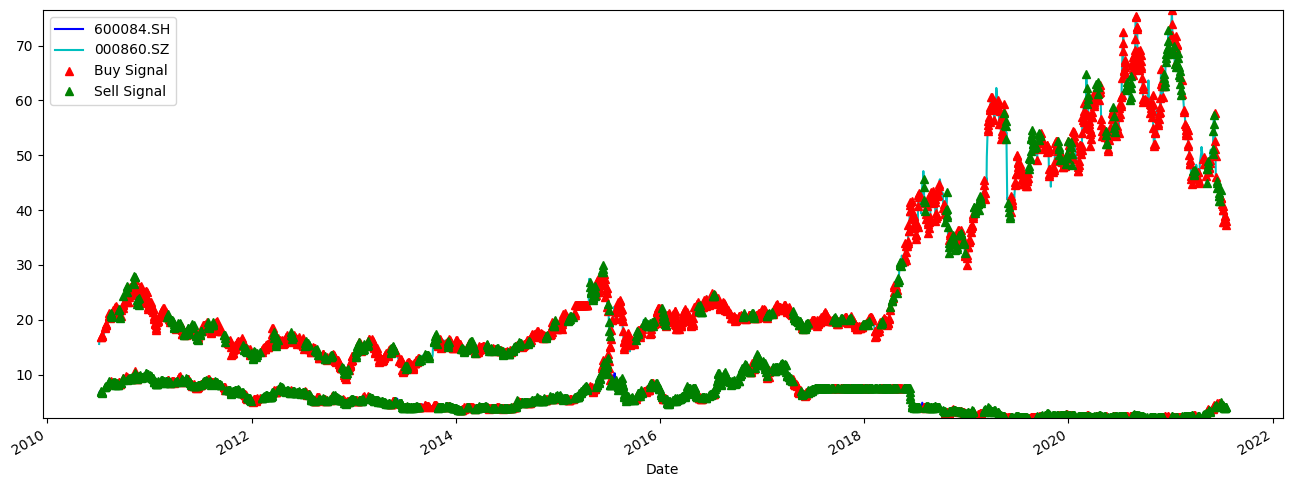

            returns1  returns2  strategy
Date                                    
2021-07-20  0.419792  0.484945  5.158596
0.5031966528320146


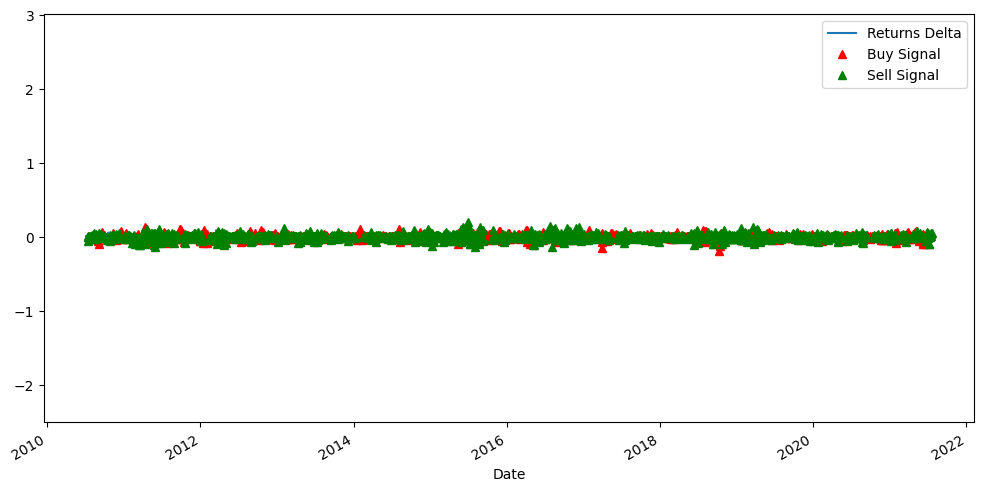

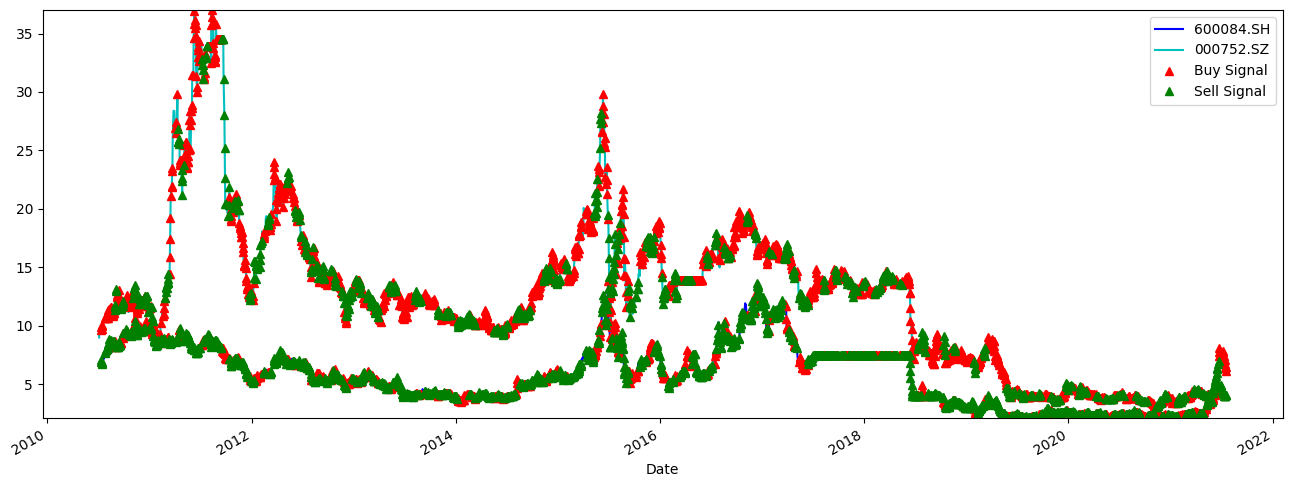

            returns1  returns2  strategy
Date                                    
2021-07-20  1.258258  4.184895  1.480425
0.29852680115163915


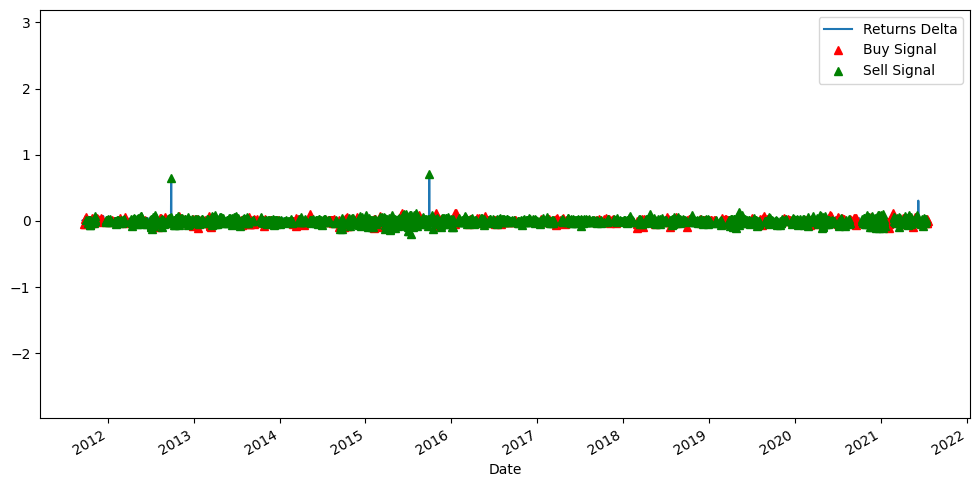

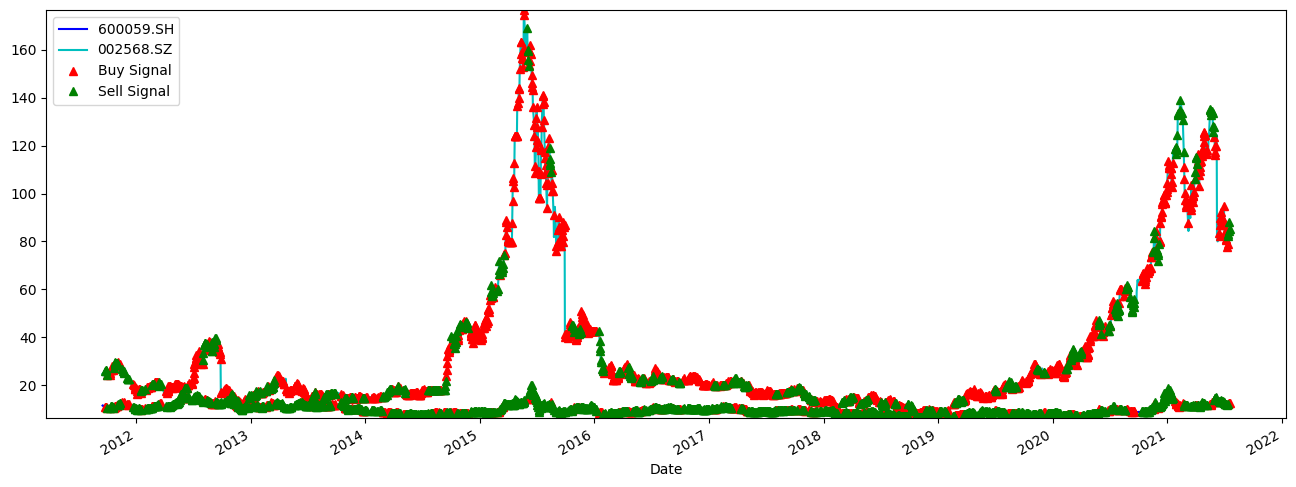

            returns1  returns2  strategy
Date                                    
2021-07-20  1.219205  1.834281  2.325313
0.7270699809680417


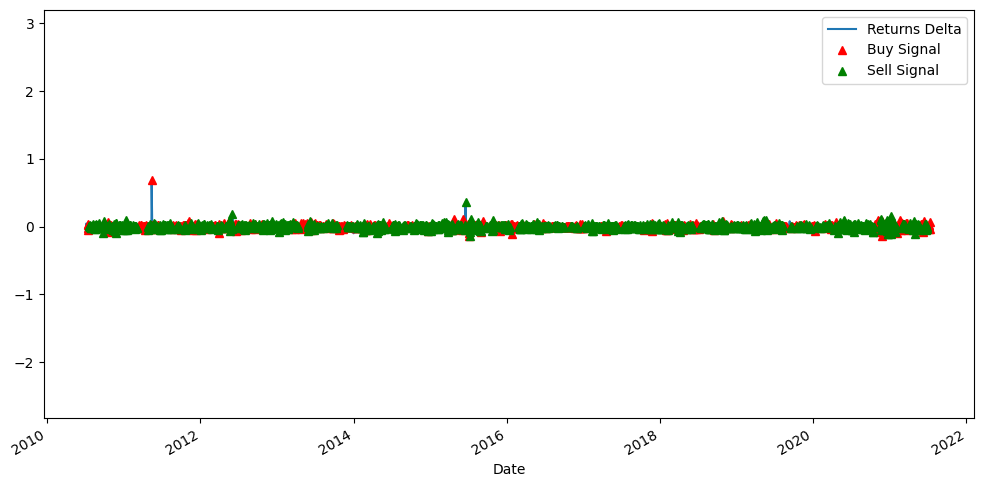

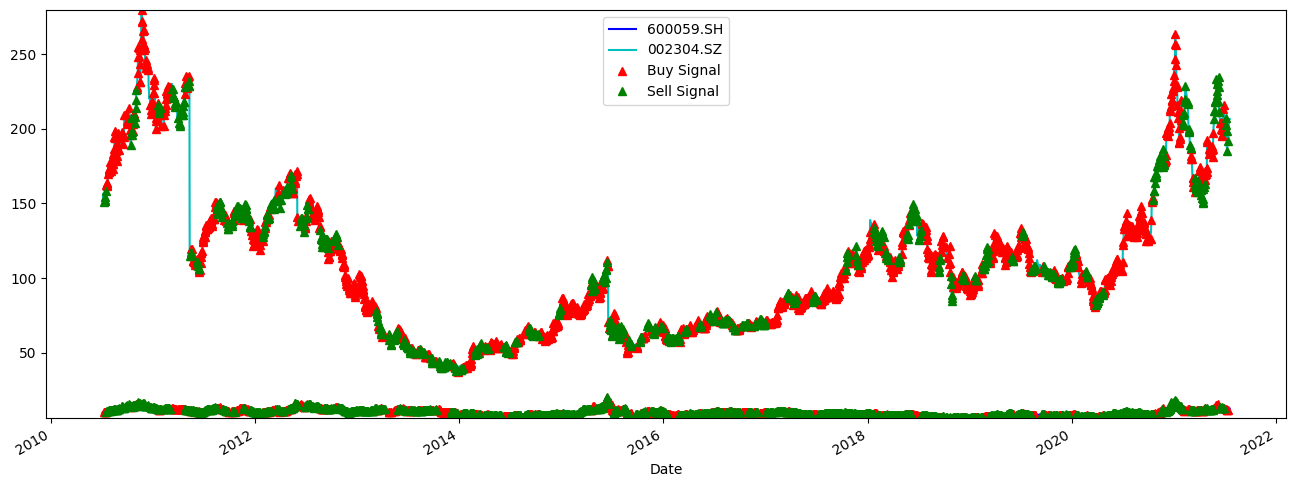

            returns1  returns2  strategy
Date                                    
2021-07-20  1.219205  0.510156   2.08146
0.4313302518818891


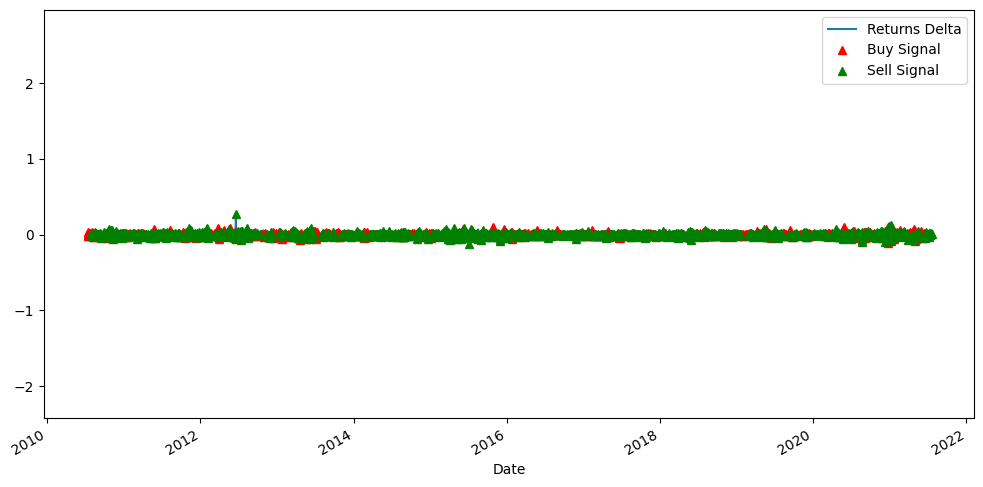

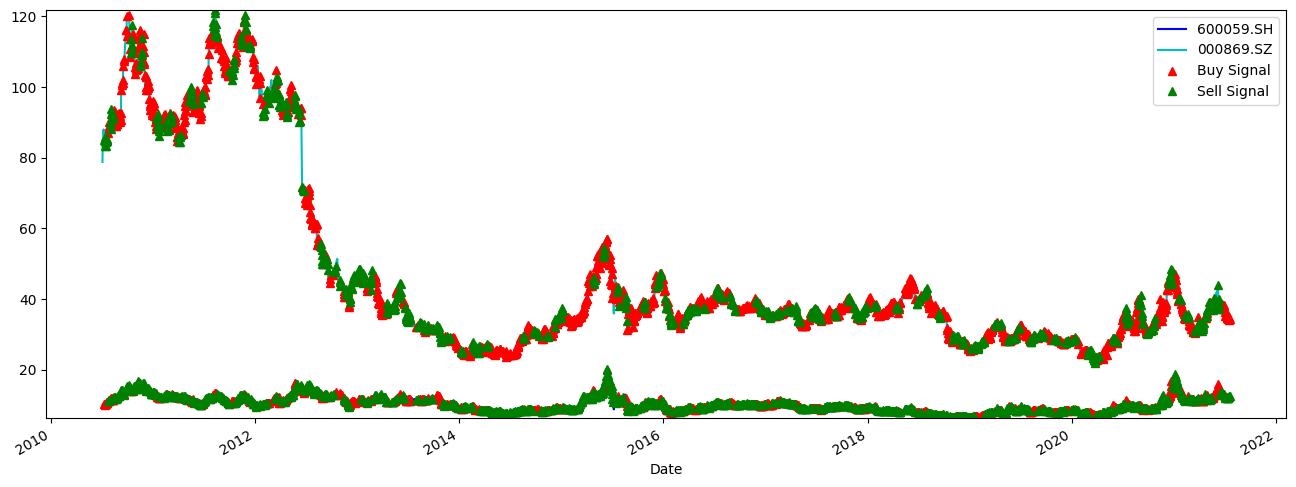

            returns1  returns2  strategy
Date                                    
2021-07-20  1.219205  2.116846   0.76411
0.4410354682187556


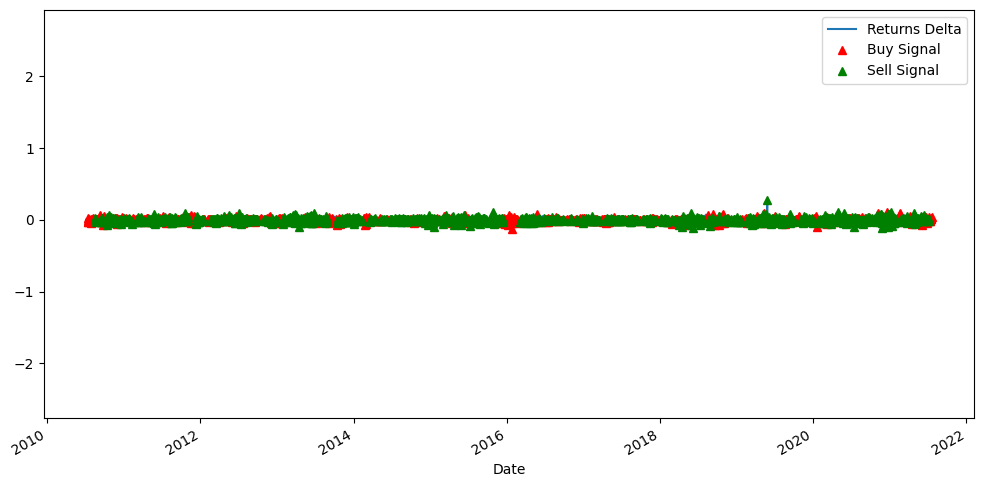

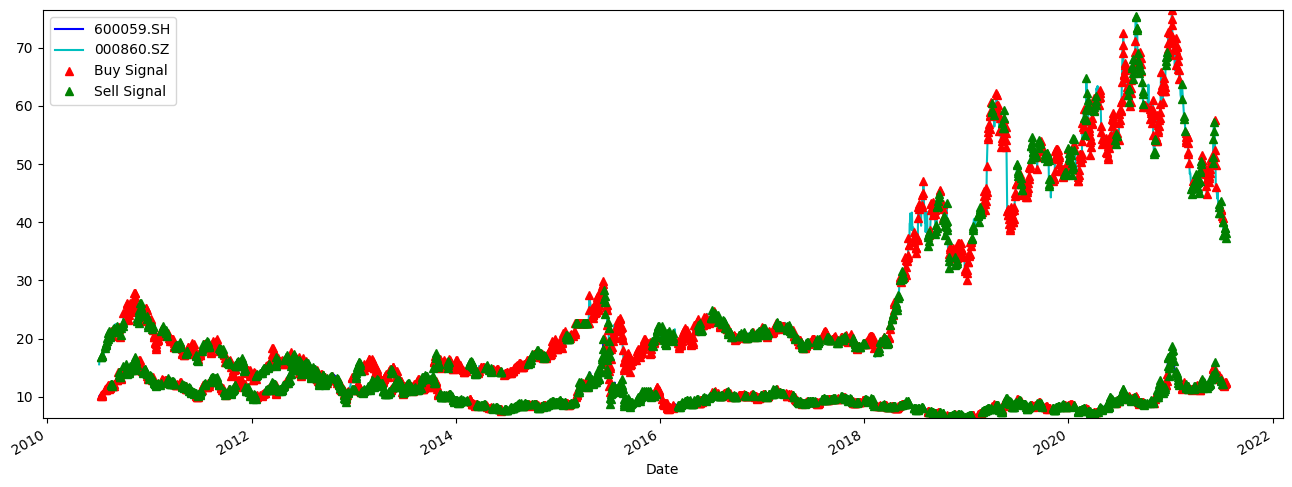

            returns1   returns2  strategy
Date                                     
2021-07-20  1.219205  15.927131  1.435163
1.8792654824430661


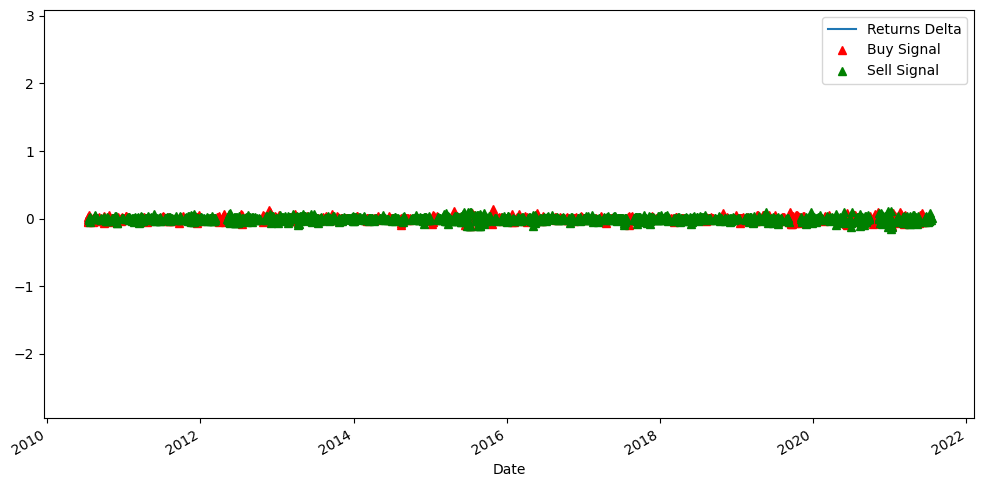

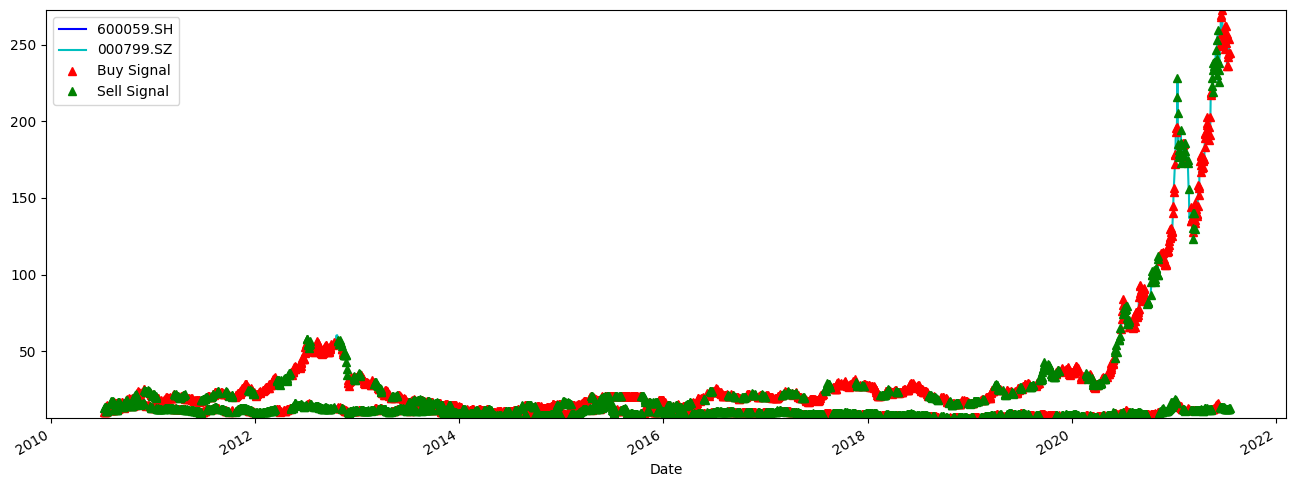

            returns1  returns2  strategy
Date                                    
2021-07-20  1.219205     0.351  0.920195
0.5344172152964272


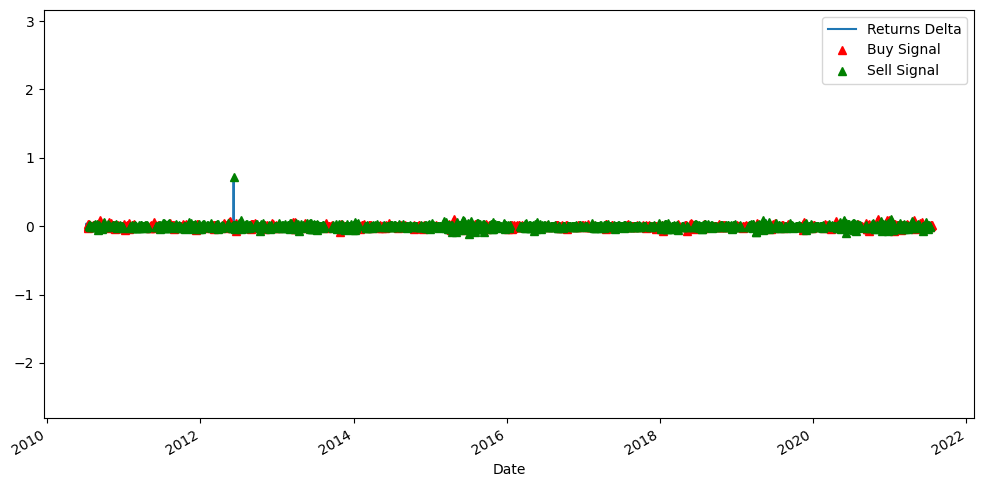

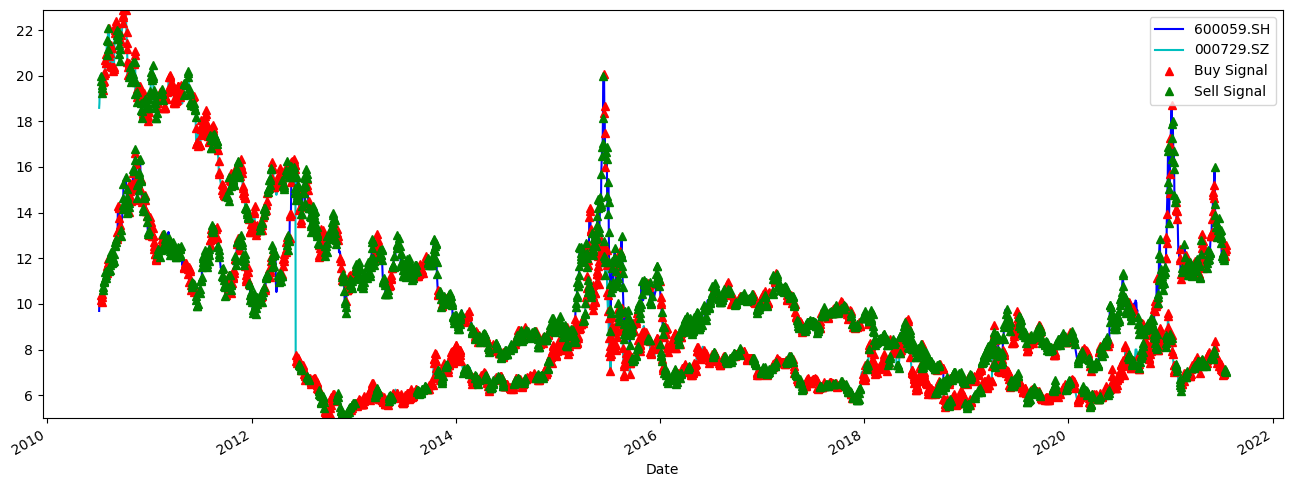

            returns1  returns2  strategy
Date                                    
2021-07-20   1.00985  2.234731  0.554522
0.48200083470713506


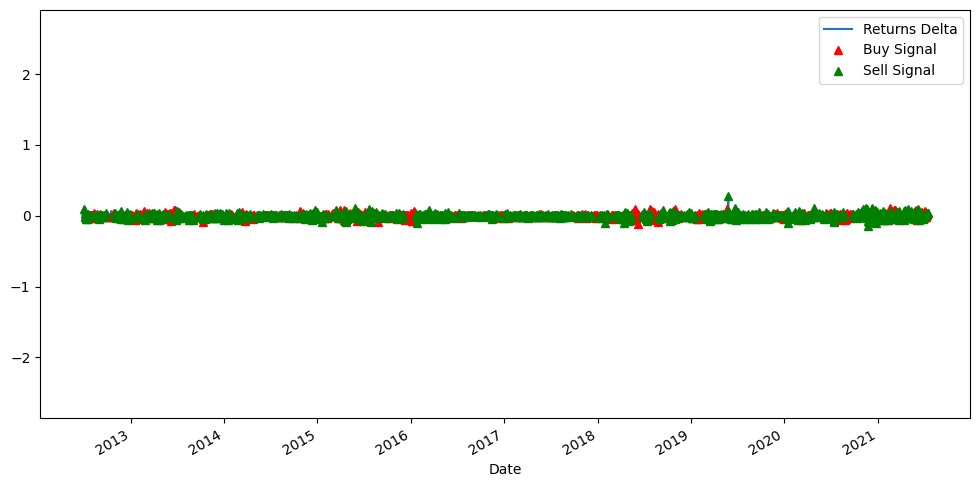

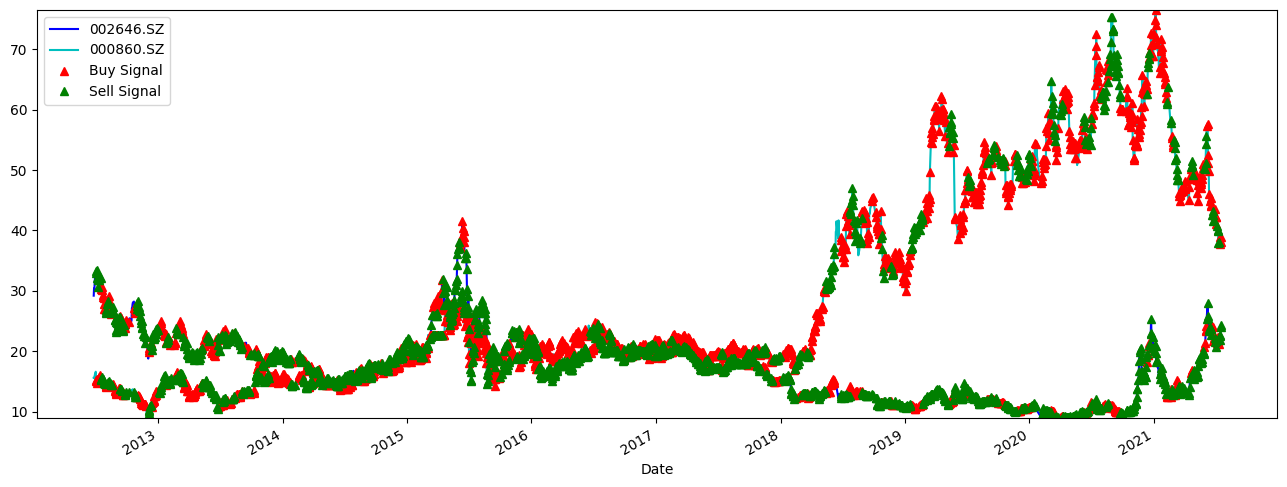

            returns1  returns2  strategy
Date                                    
2021-07-20   0.51007   0.81283  1.852526
-0.605145208943101


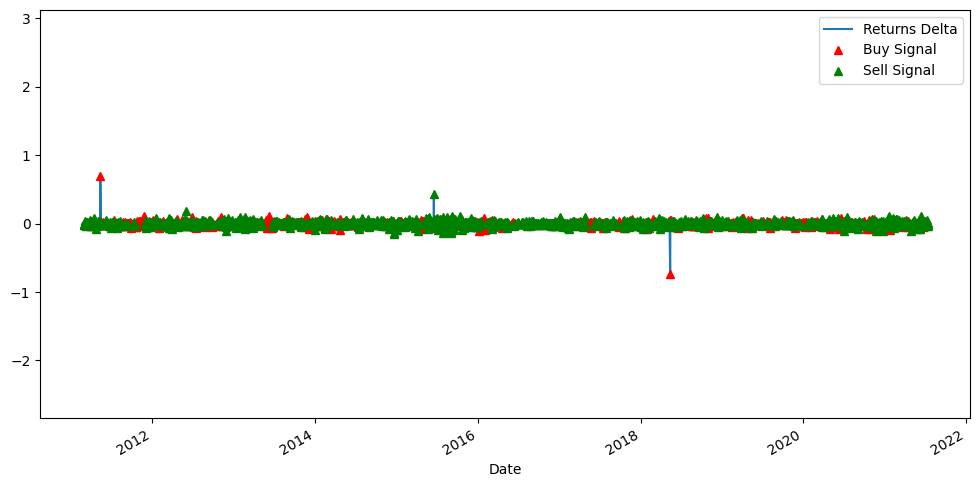

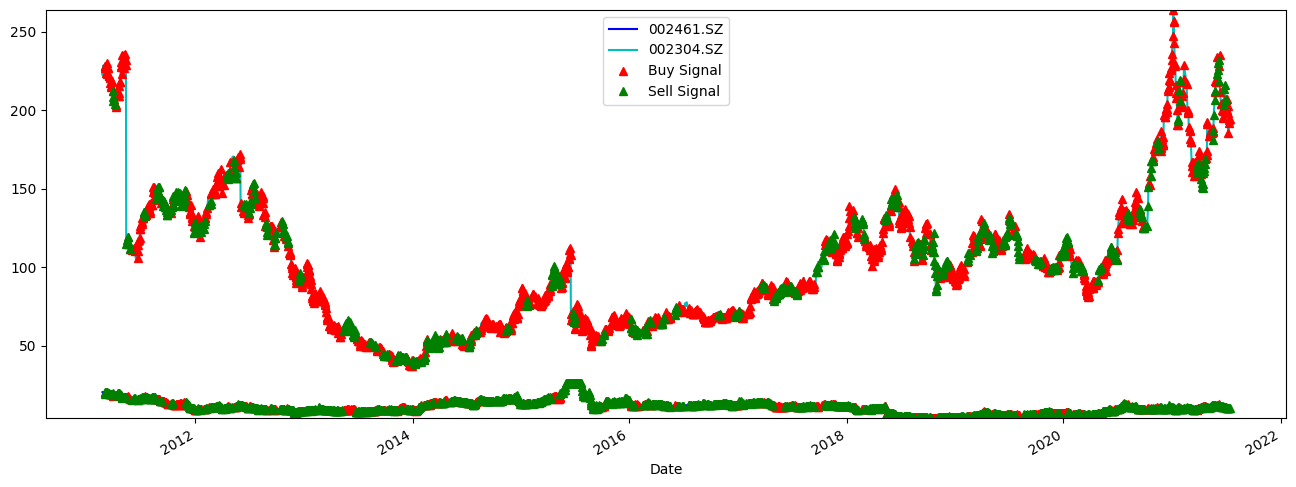

            returns1  returns2  strategy
Date                                    
2021-07-20   0.51007   1.87798  2.523146
1.7969838891205612


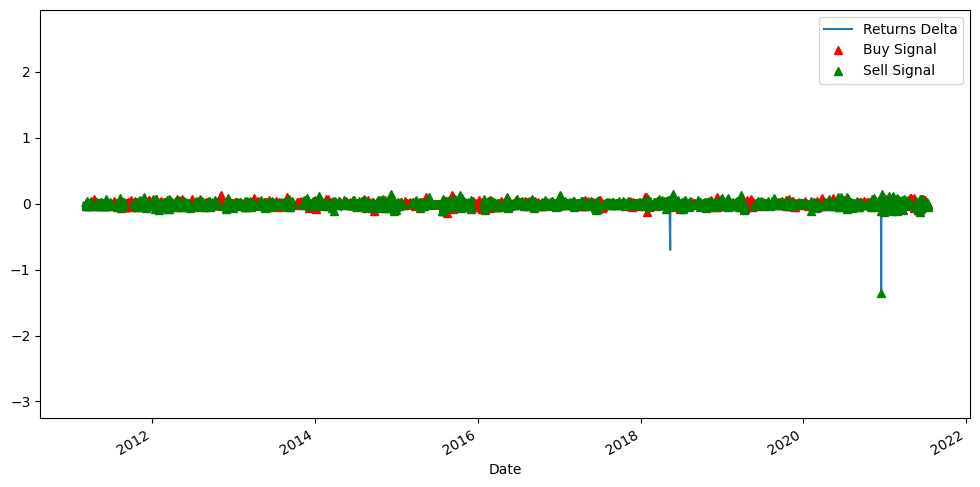

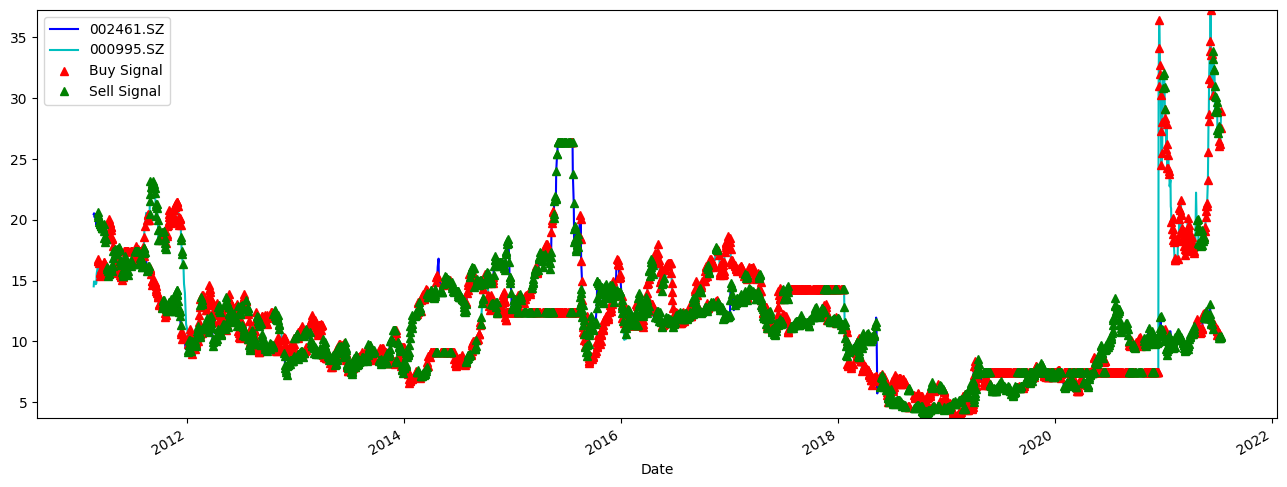

0.8008915813375594


In [23]:
#policy_net.load_state_dict(torch.load('./models/model (19).pth'))
policy_net.load_state_dict(torch.load('./models/model (6).pth'))   #copies parameters from state_dict to this module
target_net.load_state_dict(policy_net.state_dict())
policy_net.eval()   #changes forward(); disables Dropout, BatchNorm, etc.
target_net.eval()

returns = []
with torch.no_grad():
    for env in test_envs:
        obs = env.reset()
        state = torch.tensor([obs], dtype=torch.float, device=device)
        for t in count():   #keep looping until done -> break
            # Select and perform an action
            action = policy_net(state).max(1)[1].view(1, 1)
            obs, reward, done, info = env.step(Positions(action.item()))
            state = torch.tensor([obs], dtype=torch.float, device=device)

            if done:
                print(env.returns)
                print(env._total_reward)
                env.render()
                returns.append(info['total_return'])
                break

avg_returns = np.mean(returns)
print(avg_returns)

plt.ioff()
plt.show()

In [17]:
test_envs[0].df

,600543.SH,000858.SZ,ratios,zscore,position1,position2,returns1,returns2,strategy
Date,,,,,,,,,
2010-04-06,12.00,28.04,0.427960,-0.043434,0.0,-0.0,-0.014889,-0.009230,0.000000
2010-04-07,11.88,28.36,0.418900,-0.028455,0.0,-0.0,-0.010050,0.011348,-0.000000
2010-04-08,11.91,27.76,0.429035,-0.023734,0.0,-0.0,0.002522,-0.021384,0.000000
2010-04-09,12.05,28.05,0.429590,0.025610,0.0,-0.0,0.011686,0.010392,0.000000
2010-04-12,12.19,27.52,0.442951,0.195577,0.0,-0.0,0.011551,-0.019076,0.000000
...,...,...,...,...,...,...,...,...,...
2021-07-14,8.11,275.30,0.029459,1.192199,-1.0,1.0,0.008669,-0.002539,-0.005604
2021-07-15,8.18,280.83,0.029128,1.116917,-1.0,1.0,0.008594,0.019888,0.005647
2021-07-16,8.14,277.52,0.029331,1.081904,-1.0,1.0,-0.004902,-0.011857,-0.003477


In [16]:
env.get_observation()

array([ 1.6456393 ,  1.69994203,  1.6121919 ,  1.17116738,  0.70791341,
        0.49220369,  0.28231175,  0.33163876,  0.52578213,  0.81065002,
        0.8498165 ,  0.89961637,  0.95076599,  1.12619571,  0.93018687,
        0.85288347,  1.03540377,  1.20477318,  1.33735685,  1.6424206 ,
        1.79683237,  1.6296441 ,  1.50297121,  1.32210901,  0.99042736,
        0.73686185,  0.50510593,  0.17612378, -0.23804205, -0.6849999 ,
       -1.19995276, -1.59894898, -2.02059621, -2.26660196, -2.38129286,
       -2.41575328, -2.41616669, -2.32770175, -2.26648371, -2.1578047 ,
       -1.98273385, -1.88796502, -1.83248792, -1.74408091, -1.70426996,
       -1.59812967, -1.49019038, -1.41646325, -1.31331564, -1.24064728,
       -1.22550451, -1.16383018, -1.09472096, -1.04982904, -0.99667683,
       -0.91658065, -0.87238548, -0.84401098, -0.82711078, -0.84182319,
        0.        ,  0.02573553])